# Cell 1: 노트북 개요

## 06_safety_shield.ipynb - Safety Shield 구현

이 노트북에서는 규칙 기반 Safety Shield를 구현합니다.

### Shield의 목적
- Policy 모델의 출력이 안전하지 않을 때 override
- 학습 품질과 무관하게 **데모 성공률 100%** 보장
- 신호등 준수, 속도 제한, 충돌 회피 등 강제

### 참고 논문
- **Safe RL Survey** (García & Fernández, 2015): 안전 강화학습 방법론
- **Shielded RL** (Alshiekh et al., 2018): 안전 보장 강화학습

In [1]:
# Cell 1: 라이브러리 및 설정

import sys
import os
import json
import logging
import numpy as np
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Any, Optional
import matplotlib.pyplot as plt

# 프로젝트 루트
PROJECT_ROOT = Path().absolute().parent
sys.path.insert(0, str(PROJECT_ROOT))

# 로깅 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print(f"프로젝트 루트: {PROJECT_ROOT}")

프로젝트 루트: c:\git\automotive


In [2]:
# Cell 2: 설정 로드

import yaml

with open(PROJECT_ROOT / 'config' / 'model_config.yaml', 'r', encoding='utf-8') as f:
    model_config = yaml.safe_load(f)

# Shield 설정
SHIELD_CONFIG = model_config['safety_shield']
print("Safety Shield 설정:")
print(f"  활성화: {SHIELD_CONFIG['enabled']}")
print(f"  규칙:")
for rule, enabled in SHIELD_CONFIG['rules'].items():
    print(f"    - {rule}: {enabled}")
print(f"  파라미터:")
for param, value in SHIELD_CONFIG['params'].items():
    print(f"    - {param}: {value}")

Safety Shield 설정:
  활성화: True
  규칙:
    - red_light_stop: True
    - speed_limit: True
    - collision_avoid: True
    - pedestrian_priority: True
  파라미터:
    - emergency_brake_distance: 5.0
    - speed_limit_margin: 5.0
    - pedestrian_safe_distance: 10.0


In [3]:
# Cell 3: 차량 상태 데이터 클래스

@dataclass
class VehicleState:
    """
    차량 상태 정보
    
    Shield가 안전 결정을 내리기 위해 필요한 정보
    """
    # 기본 상태
    speed: float = 0.0  # m/s
    speed_limit: float = 50.0  # km/h
    
    # 신호등
    traffic_light: str = 'none'  # 'red', 'yellow', 'green', 'none'
    distance_to_traffic_light: float = float('inf')  # 미터
    
    # 장애물
    obstacle_distance: float = float('inf')  # 미터
    obstacle_type: str = 'none'  # 'vehicle', 'pedestrian', 'none'
    
    # 차선
    lane_invasion: bool = False
    
    def speed_kmh(self) -> float:
        """속도를 km/h로 반환"""
        return self.speed * 3.6
    
    def is_over_speed_limit(self, margin: float = 0.0) -> bool:
        """속도 제한 초과 여부"""
        return self.speed_kmh() > (self.speed_limit + margin)

@dataclass
class Action:
    """
    차량 제어 액션
    """
    steer: float = 0.0  # [-1, 1]
    throttle: float = 0.0  # [0, 1]
    brake: float = 0.0  # [0, 1]
    
    def to_dict(self) -> Dict[str, float]:
        return {'steer': self.steer, 'throttle': self.throttle, 'brake': self.brake}
    
    def to_array(self) -> np.ndarray:
        return np.array([self.steer, self.throttle, self.brake])
    
    @classmethod
    def from_array(cls, arr: np.ndarray) -> 'Action':
        return cls(steer=arr[0], throttle=arr[1], brake=arr[2])

print("✅ VehicleState, Action 클래스 정의 완료")

✅ VehicleState, Action 클래스 정의 완료


In [4]:
# Cell 4: Safety Shield 클래스

class SafetyShield:
    """
    규칙 기반 안전 장치 (Safety Shield)
    
    Policy 모델의 출력을 받아 안전하지 않으면 override
    
    설계 원칙:
    1. 안전 > 효율: 안전하지 않은 행동은 무조건 차단
    2. 최소 개입: 필요한 경우에만 override
    3. 투명성: 어떤 규칙이 적용되었는지 로깅
    
    참고: García & Fernández (2015) - Safe Reinforcement Learning 서베이
    """
    
    def __init__(self, config: Dict[str, Any] = None):
        config = config or SHIELD_CONFIG
        
        self.enabled = config.get('enabled', True)
        self.rules = config.get('rules', {})
        self.params = config.get('params', {})
        
        # 규칙별 통계
        self.stats = {
            'total_calls': 0,
            'interventions': 0,
            'red_light_stops': 0,
            'speed_limit_clamps': 0,
            'collision_brakes': 0,
            'pedestrian_stops': 0
        }
        
        logger.info(f"SafetyShield 초기화: enabled={self.enabled}")
    
    def apply(self, action: Action, state: VehicleState) -> tuple:
        """
        안전 규칙 적용
        
        Args:
            action: Policy 모델의 출력 액션
            state: 현재 차량 상태
        
        Returns:
            tuple: (safe_action, applied_rules)
        """
        self.stats['total_calls'] += 1
        
        if not self.enabled:
            return action, []
        
        safe_action = Action(
            steer=action.steer,
            throttle=action.throttle,
            brake=action.brake
        )
        applied_rules = []
        
        # 규칙 1: 빨간불 정지
        if self.rules.get('red_light_stop', True):
            if state.traffic_light == 'red':
                safe_action.throttle = 0.0
                safe_action.brake = 1.0
                applied_rules.append('red_light_stop')
                self.stats['red_light_stops'] += 1
        
        # 규칙 2: 황색신호 감속
        if self.rules.get('red_light_stop', True):
            if state.traffic_light == 'yellow':
                safe_action.throttle = min(safe_action.throttle, 0.3)
                safe_action.brake = max(safe_action.brake, 0.3)
                applied_rules.append('yellow_light_slow')
        
        # 규칙 3: 속도 제한
        if self.rules.get('speed_limit', True):
            margin = self.params.get('speed_limit_margin', 5.0)
            if state.is_over_speed_limit(margin):
                safe_action.throttle = 0.0
                applied_rules.append('speed_limit')
                self.stats['speed_limit_clamps'] += 1
        
        # 규칙 4: 충돌 회피 (일반 장애물)
        if self.rules.get('collision_avoid', True):
            emergency_dist = self.params.get('emergency_brake_distance', 5.0)
            if state.obstacle_distance < emergency_dist:
                # 거리에 반비례하는 제동력
                brake_force = min(1.0, emergency_dist / max(state.obstacle_distance, 0.1))
                safe_action.brake = max(safe_action.brake, brake_force)
                safe_action.throttle = 0.0
                applied_rules.append('collision_avoid')
                self.stats['collision_brakes'] += 1
        
        # 규칙 5: 보행자 우선 (더 넓은 안전 거리)
        if self.rules.get('pedestrian_priority', True):
            ped_safe_dist = self.params.get('pedestrian_safe_distance', 10.0)
            if state.obstacle_type == 'pedestrian' and state.obstacle_distance < ped_safe_dist:
                safe_action.throttle = 0.0
                safe_action.brake = 1.0
                applied_rules.append('pedestrian_priority')
                self.stats['pedestrian_stops'] += 1
        
        # 개입 통계 업데이트
        if applied_rules:
            self.stats['interventions'] += 1
        
        return safe_action, applied_rules
    
    def get_stats(self) -> Dict[str, Any]:
        """통계 반환"""
        stats = self.stats.copy()
        if stats['total_calls'] > 0:
            stats['intervention_rate'] = stats['interventions'] / stats['total_calls']
        else:
            stats['intervention_rate'] = 0.0
        return stats
    
    def reset_stats(self):
        """통계 초기화"""
        for key in self.stats:
            self.stats[key] = 0

print("✅ SafetyShield 클래스 정의 완료")

✅ SafetyShield 클래스 정의 완료


In [5]:
# Cell 5: Shield 테스트 - 빨간불 정지

shield = SafetyShield()

print("=" * 50)
print("테스트 1: 빨간불 정지")
print("=" * 50)

# Policy가 가속하려 하지만 빨간불
policy_action = Action(steer=0.0, throttle=0.8, brake=0.0)
state = VehicleState(speed=10.0, traffic_light='red')

safe_action, rules = shield.apply(policy_action, state)

print(f"Policy 액션: steer={policy_action.steer:.2f}, throttle={policy_action.throttle:.2f}, brake={policy_action.brake:.2f}")
print(f"차량 상태: speed={state.speed_kmh():.1f} km/h, 신호등={state.traffic_light}")
print(f"\nShield 적용 후:")
print(f"  Safe 액션: steer={safe_action.steer:.2f}, throttle={safe_action.throttle:.2f}, brake={safe_action.brake:.2f}")
print(f"  적용된 규칙: {rules}")

2025-12-14 21:45:42,014 - INFO - SafetyShield 초기화: enabled=True


테스트 1: 빨간불 정지
Policy 액션: steer=0.00, throttle=0.80, brake=0.00
차량 상태: speed=36.0 km/h, 신호등=red

Shield 적용 후:
  Safe 액션: steer=0.00, throttle=0.00, brake=1.00
  적용된 규칙: ['red_light_stop']


In [6]:
# Cell 6: Shield 테스트 - 속도 제한

print("=" * 50)
print("테스트 2: 속도 제한")
print("=" * 50)

# Policy가 가속하려 하지만 속도 초과
policy_action = Action(steer=0.0, throttle=0.9, brake=0.0)
state = VehicleState(speed=16.0, speed_limit=50.0)  # 57.6 km/h > 50 km/h + margin

safe_action, rules = shield.apply(policy_action, state)

print(f"Policy 액션: throttle={policy_action.throttle:.2f}")
print(f"차량 상태: speed={state.speed_kmh():.1f} km/h, 제한={state.speed_limit} km/h")
print(f"\nShield 적용 후:")
print(f"  Safe 액션: throttle={safe_action.throttle:.2f}, brake={safe_action.brake:.2f}")
print(f"  적용된 규칙: {rules}")

테스트 2: 속도 제한
Policy 액션: throttle=0.90
차량 상태: speed=57.6 km/h, 제한=50.0 km/h

Shield 적용 후:
  Safe 액션: throttle=0.00, brake=0.00
  적용된 규칙: ['speed_limit']


In [7]:
# Cell 7: Shield 테스트 - 긴급 충돌 회피

print("=" * 50)
print("테스트 3: 긴급 충돌 회피")
print("=" * 50)

# 전방 장애물
policy_action = Action(steer=0.0, throttle=0.5, brake=0.0)
state = VehicleState(speed=10.0, obstacle_distance=3.0, obstacle_type='vehicle')

safe_action, rules = shield.apply(policy_action, state)

print(f"Policy 액션: throttle={policy_action.throttle:.2f}")
print(f"차량 상태: 장애물 거리={state.obstacle_distance}m, 유형={state.obstacle_type}")
print(f"\nShield 적용 후:")
print(f"  Safe 액션: throttle={safe_action.throttle:.2f}, brake={safe_action.brake:.2f}")
print(f"  적용된 규칙: {rules}")

테스트 3: 긴급 충돌 회피
Policy 액션: throttle=0.50
차량 상태: 장애물 거리=3.0m, 유형=vehicle

Shield 적용 후:
  Safe 액션: throttle=0.00, brake=1.00
  적용된 규칙: ['collision_avoid']


In [8]:
# Cell 8: Shield 테스트 - 보행자 우선

print("=" * 50)
print("테스트 4: 보행자 우선")
print("=" * 50)

# 보행자 근접 (더 넓은 안전 거리)
policy_action = Action(steer=0.0, throttle=0.3, brake=0.0)
state = VehicleState(speed=5.0, obstacle_distance=8.0, obstacle_type='pedestrian')

safe_action, rules = shield.apply(policy_action, state)

print(f"Policy 액션: throttle={policy_action.throttle:.2f}")
print(f"차량 상태: 보행자 거리={state.obstacle_distance}m")
print(f"\nShield 적용 후:")
print(f"  Safe 액션: throttle={safe_action.throttle:.2f}, brake={safe_action.brake:.2f}")
print(f"  적용된 규칙: {rules}")

테스트 4: 보행자 우선
Policy 액션: throttle=0.30
차량 상태: 보행자 거리=8.0m

Shield 적용 후:
  Safe 액션: throttle=0.00, brake=1.00
  적용된 규칙: ['pedestrian_priority']


In [9]:
# Cell 9: Shield 테스트 - 규칙 미적용 (안전한 상황)

print("=" * 50)
print("테스트 5: 안전한 상황 (규칙 미적용)")
print("=" * 50)

# 안전한 상황에서는 Policy 그대로
policy_action = Action(steer=0.1, throttle=0.5, brake=0.0)
state = VehicleState(
    speed=8.0,  # ~29 km/h < 50 km/h
    speed_limit=50.0,
    traffic_light='green',
    obstacle_distance=50.0
)

safe_action, rules = shield.apply(policy_action, state)

print(f"Policy 액션: steer={policy_action.steer:.2f}, throttle={policy_action.throttle:.2f}")
print(f"차량 상태: speed={state.speed_kmh():.1f} km/h, 신호={state.traffic_light}, 장애물={state.obstacle_distance}m")
print(f"\nShield 적용 후:")
print(f"  Safe 액션: steer={safe_action.steer:.2f}, throttle={safe_action.throttle:.2f}")
print(f"  적용된 규칙: {rules}")
print(f"\n→ 안전한 상황에서는 Policy 출력 그대로 사용")

테스트 5: 안전한 상황 (규칙 미적용)
Policy 액션: steer=0.10, throttle=0.50
차량 상태: speed=28.8 km/h, 신호=green, 장애물=50.0m

Shield 적용 후:
  Safe 액션: steer=0.10, throttle=0.50
  적용된 규칙: []

→ 안전한 상황에서는 Policy 출력 그대로 사용


In [10]:
# Cell 10: Shield 통계 확인

print("=" * 50)
print("Shield 통계")
print("=" * 50)

stats = shield.get_stats()
for key, value in stats.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.2%}")
    else:
        print(f"  {key}: {value}")

Shield 통계
  total_calls: 5
  interventions: 4
  red_light_stops: 1
  speed_limit_clamps: 1
  collision_brakes: 1
  pedestrian_stops: 1
  intervention_rate: 80.00%


In [11]:
# Cell 11: Policy + Shield 통합 클래스

import torch
import torch.nn as nn

class ShieldedPolicy:
    """
    Policy 모델 + Safety Shield 통합
    
    사용법:
    1. Policy 모델이 이미지를 보고 액션 예측
    2. Shield가 현재 상태를 보고 안전하지 않으면 override
    """
    
    def __init__(self, policy_model: nn.Module, shield: SafetyShield, device='cuda'):
        self.policy = policy_model
        self.shield = shield
        self.device = device
        self.policy.eval()
    
    def predict(self, image: torch.Tensor, state: VehicleState) -> tuple:
        """
        안전한 액션 예측
        
        Args:
            image: 입력 이미지 텐서 [1, 3, H, W]
            state: 현재 차량 상태
        
        Returns:
            tuple: (safe_action, policy_action, applied_rules)
        """
        # Policy 예측
        with torch.no_grad():
            image = image.to(self.device)
            action_tensor = self.policy(image)
            action_np = action_tensor.cpu().numpy()[0]
        
        policy_action = Action.from_array(action_np)
        
        # Shield 적용
        safe_action, applied_rules = self.shield.apply(policy_action, state)
        
        return safe_action, policy_action, applied_rules
    
    def get_shield_stats(self) -> Dict[str, Any]:
        """Shield 통계 반환"""
        return self.shield.get_stats()

print("✅ ShieldedPolicy 클래스 정의 완료")

✅ ShieldedPolicy 클래스 정의 완료


2025-12-14 21:45:43,852 - INFO - SafetyShield 초기화: enabled=True


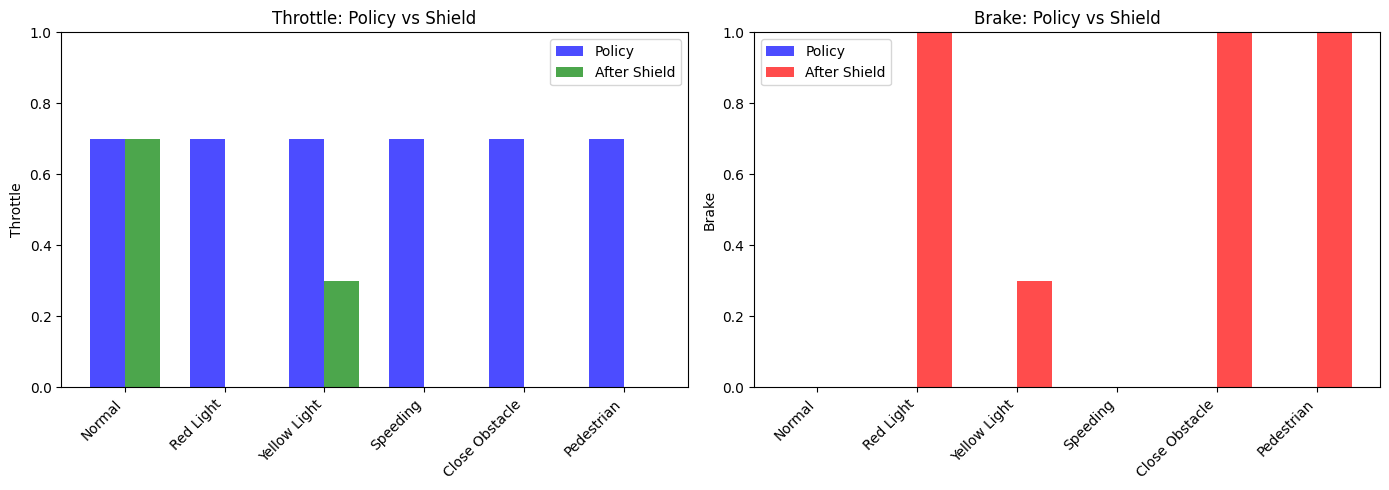


적용된 규칙:
  Normal: None
  Red Light: red_light_stop
  Yellow Light: yellow_light_slow
  Speeding: speed_limit
  Close Obstacle: collision_avoid
  Pedestrian: pedestrian_priority


In [12]:
# Cell 12: Shield 동작 시각화

def visualize_shield_behavior():
    """
    다양한 시나리오에서 Shield 동작 시각화
    """
    shield = SafetyShield()
    shield.reset_stats()
    
    # 시나리오 정의
    scenarios = [
        {'name': 'Normal', 'light': 'green', 'speed': 30, 'obstacle': float('inf')},
        {'name': 'Red Light', 'light': 'red', 'speed': 30, 'obstacle': float('inf')},
        {'name': 'Yellow Light', 'light': 'yellow', 'speed': 30, 'obstacle': float('inf')},
        {'name': 'Speeding', 'light': 'green', 'speed': 60, 'obstacle': float('inf')},
        {'name': 'Close Obstacle', 'light': 'green', 'speed': 30, 'obstacle': 4},
        {'name': 'Pedestrian', 'light': 'green', 'speed': 20, 'obstacle': 8, 'ped': True},
    ]
    
    # Policy 기본 액션 (가속)
    policy_action = Action(steer=0.0, throttle=0.7, brake=0.0)
    
    results = []
    for scenario in scenarios:
        state = VehicleState(
            speed=scenario['speed'] / 3.6,  # km/h -> m/s
            speed_limit=50.0,
            traffic_light=scenario['light'],
            obstacle_distance=scenario['obstacle'],
            obstacle_type='pedestrian' if scenario.get('ped') else 'vehicle'
        )
        
        safe_action, rules = shield.apply(policy_action, state)
        
        results.append({
            'scenario': scenario['name'],
            'policy_throttle': policy_action.throttle,
            'policy_brake': policy_action.brake,
            'safe_throttle': safe_action.throttle,
            'safe_brake': safe_action.brake,
            'rules': rules
        })
    
    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    names = [r['scenario'] for r in results]
    policy_throttle = [r['policy_throttle'] for r in results]
    safe_throttle = [r['safe_throttle'] for r in results]
    policy_brake = [r['policy_brake'] for r in results]
    safe_brake = [r['safe_brake'] for r in results]
    
    x = np.arange(len(names))
    width = 0.35
    
    # Throttle
    axes[0].bar(x - width/2, policy_throttle, width, label='Policy', color='blue', alpha=0.7)
    axes[0].bar(x + width/2, safe_throttle, width, label='After Shield', color='green', alpha=0.7)
    axes[0].set_ylabel('Throttle')
    axes[0].set_title('Throttle: Policy vs Shield')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(names, rotation=45, ha='right')
    axes[0].legend()
    axes[0].set_ylim(0, 1)
    
    # Brake
    axes[1].bar(x - width/2, policy_brake, width, label='Policy', color='blue', alpha=0.7)
    axes[1].bar(x + width/2, safe_brake, width, label='After Shield', color='red', alpha=0.7)
    axes[1].set_ylabel('Brake')
    axes[1].set_title('Brake: Policy vs Shield')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(names, rotation=45, ha='right')
    axes[1].legend()
    axes[1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    # 적용된 규칙 출력
    print("\n적용된 규칙:")
    for r in results:
        rules_str = ', '.join(r['rules']) if r['rules'] else 'None'
        print(f"  {r['scenario']}: {rules_str}")

visualize_shield_behavior()

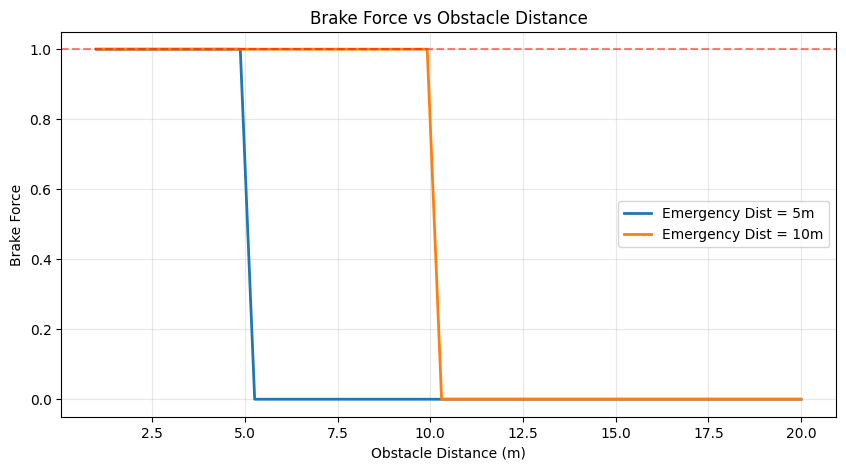

In [13]:
# Cell 13: Shield 파라미터 튜닝 분석

def analyze_parameter_sensitivity():
    """
    Shield 파라미터 민감도 분석
    """
    # Emergency brake distance 변화에 따른 brake 강도
    distances = np.linspace(1, 20, 50)
    
    brake_forces_5m = []  # emergency_dist = 5m
    brake_forces_10m = []  # emergency_dist = 10m
    
    for dist in distances:
        # 5m 설정
        if dist < 5:
            brake_forces_5m.append(min(1.0, 5 / max(dist, 0.1)))
        else:
            brake_forces_5m.append(0)
        
        # 10m 설정
        if dist < 10:
            brake_forces_10m.append(min(1.0, 10 / max(dist, 0.1)))
        else:
            brake_forces_10m.append(0)
    
    plt.figure(figsize=(10, 5))
    plt.plot(distances, brake_forces_5m, label='Emergency Dist = 5m', linewidth=2)
    plt.plot(distances, brake_forces_10m, label='Emergency Dist = 10m', linewidth=2)
    plt.xlabel('Obstacle Distance (m)')
    plt.ylabel('Brake Force')
    plt.title('Brake Force vs Obstacle Distance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Max Brake')
    plt.show()

analyze_parameter_sensitivity()

In [14]:
# Cell 14: Shield 저장 및 요약

import pickle

# Shield 설정 저장
shield_config = {
    'enabled': SHIELD_CONFIG['enabled'],
    'rules': SHIELD_CONFIG['rules'],
    'params': SHIELD_CONFIG['params'],
    'description': {
        'red_light_stop': '빨간불 시 완전 정지',
        'speed_limit': '속도 제한 초과 시 throttle 차단',
        'collision_avoid': '전방 장애물 근접 시 긴급 제동',
        'pedestrian_priority': '보행자 근접 시 완전 정지 (넓은 안전 거리)'
    }
}

shield_path = PROJECT_ROOT / 'checkpoints' / 'shield_config.json'
shield_path.parent.mkdir(parents=True, exist_ok=True)

with open(shield_path, 'w') as f:
    json.dump(shield_config, f, indent=2)

print(f"✅ Shield 설정 저장: {shield_path}")

print(f"\n{'='*50}")
print("Safety Shield 구현 완료")
print(f"{'='*50}")
print(f"\n다음 단계: 07_evaluation.ipynb")

✅ Shield 설정 저장: c:\git\automotive\checkpoints\shield_config.json

Safety Shield 구현 완료

다음 단계: 07_evaluation.ipynb


## Safety Shield 요약

### 구현된 규칙

| 규칙 | 조건 | 액션 |
|------|------|------|
| **빨간불 정지** | traffic_light == 'red' | throttle=0, brake=1 |
| **황색신호 감속** | traffic_light == 'yellow' | throttle≤0.3, brake≥0.3 |
| **속도 제한** | speed > limit + margin | throttle=0 |
| **충돌 회피** | obstacle < 5m | brake ∝ 1/distance |
| **보행자 우선** | pedestrian < 10m | throttle=0, brake=1 |

### 설계 원칙
1. **안전 > 효율**: 안전하지 않은 행동은 무조건 차단
2. **최소 개입**: 필요한 경우에만 override
3. **투명성**: 어떤 규칙이 적용되었는지 로깅

### 참고 논문

| 논문 | 핵심 아이디어 |
|------|---------------|
| Safe RL Survey (García & Fernández, 2015) | 안전 강화학습 방법론 종합, constraint 기반 접근 |
| Shielded RL (Alshiekh et al., 2018) | 학습과 검증 분리, 형식 검증 기반 안전 보장 |
| SafeRL (Achiam et al., 2017) | Constrained Policy Optimization (CPO) |